# Setup

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

## Caricamento dataset

In [41]:
df = pd.read_csv("../data/processed/preprocessed_data.csv", encoding='latin1')
df.head()

,label,text,cleaned_text
0,neutral,"According to Gran , the company has no plans t...",according gran company plan move production ru...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less NUM s...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,according company updated strategy year NUM NU...


## Verifica se numeri, percentuali e valute sono state normalizzate correttamente

In [42]:
# Seleziona righe che contengono numeri o valute nel testo originale

pattern = r'\d+|€|\$|euro|eur|dollari|usd'
df_sample = df[df['text'].str.contains(pattern, case=False, na=False)].copy()


for idx, row in df_sample.head(5).iterrows():
    print(f"\n ORIGINALE:   {row['text']}")
    print(f"PREPROCESS: {row['cleaned_text']}")


 ORIGINALE:   Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .
PREPROCESS: technopolis plan develop stage area less NUM square meter order host company working computer technology telecommunication statement said

 ORIGINALE:   According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .
PREPROCESS: according company updated strategy year NUM NUM basware target longterm net sale growth range NUM_PERCENT NUM_PERCENT operating profit margin NUM_PERCENT NUM_PERCENT net sale

 ORIGINALE:   For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
PREPROCESS: last quarter NUM 

## Distribuzione della lunghezza del testo (dataset preprocessato)

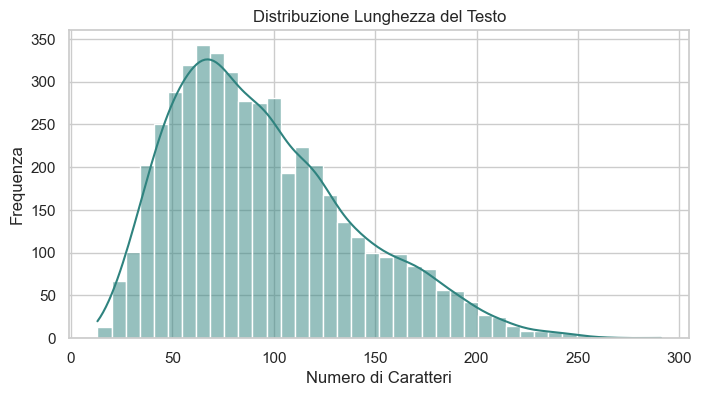

Statistiche sulla lunghezza delle frasi:
Media della lunghezza delle frasi: 95.02
Mediana della lunghezza delle frasi: 87.0
Lunghezza minima delle frasi: 13
Lunghezza massima delle frasi: 291


In [43]:
df['text_len'] = df['cleaned_text'].astype(str).apply(len)

plt.figure(figsize=(8,4))
sns.histplot(df['text_len'], bins=40, kde=True, color='#2f837f')
plt.title("Distribuzione Lunghezza del Testo")
plt.xlabel("Numero di Caratteri")
plt.ylabel("Frequenza")
plt.show()
print("Statistiche sulla lunghezza delle frasi:")
print(f"Media della lunghezza delle frasi: {df['text_len'].mean():.2f}")
print(f"Mediana della lunghezza delle frasi: {df['text_len'].median()}")
print(f"Lunghezza minima delle frasi: {df['text_len'].min()}")
print(f"Lunghezza massima delle frasi: {df['text_len'].max()}")

## Boxplot per la lunghezza delle frasi (in numero di caratteri)

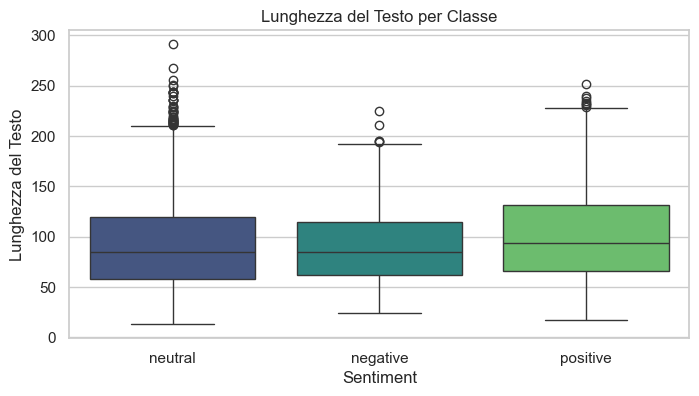


Classe: neutral
Numero di outlier: 45
Media: 92.50
Mediana: 85.0
Min: 13
Max: 291

Classe: negative
Numero di outlier: 5
Media: 92.38
Mediana: 85.0
Min: 24
Max: 225

Classe: positive
Numero di outlier: 8
Media: 101.46
Mediana: 94.0
Min: 17
Max: 252


In [44]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='label', hue='label',y='text_len', palette='viridis')
plt.title("Lunghezza del Testo per Classe")
plt.xlabel("Sentiment")
plt.ylabel("Lunghezza del Testo")
plt.show()


for label in df['label'].unique():
    subset = df[df['label'] == label]
    Q1 = subset['text_len'].quantile(0.25)
    Q3 = subset['text_len'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    label_outliers = subset[(subset['text_len'] < lower_bound) | (subset['text_len'] > upper_bound)]

    print(f"\nClasse: {label}")
    print(f"Numero di outlier: {label_outliers.shape[0]}")
    print(f"Media: {subset['text_len'].mean():.2f}")
    print(f"Mediana: {subset['text_len'].median()}")
    print(f"Min: {subset['text_len'].min()}")
    print(f"Max: {subset['text_len'].max()}")


## Violion plot per il confronto tra i due dataset (originale-preprocessato)

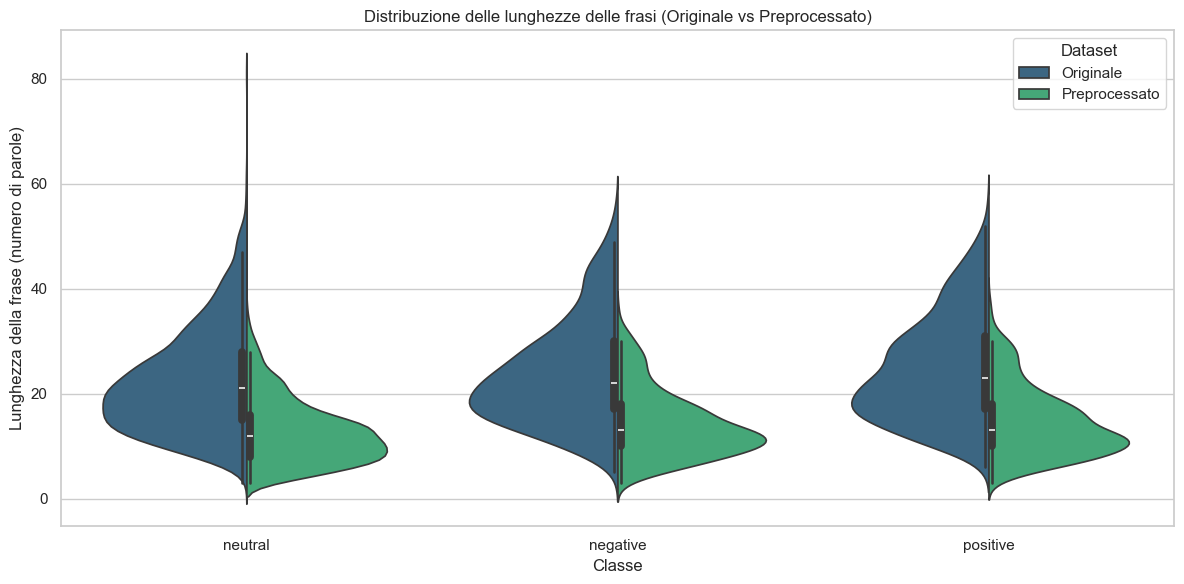

Classe: neutral
  - Originale: media=22.31, mediana=21.0, max=81, min=3
  - Preprocessato: media=12.76, mediana=12.0, max=75, min=3

Classe: negative
  - Originale: media=23.94, mediana=22.0, max=56, min=5
  - Preprocessato: media=14.24, mediana=13.0, max=36, min=3

Classe: positive
  - Originale: media=24.71, mediana=23.0, max=57, min=6
  - Preprocessato: media=14.62, mediana=13.0, max=39, min=3



In [45]:
# Calcolo lunghezza (in numero di parole) delle frasi originali e preprocessate
df['length_original'] = df['text'].apply(str).apply(lambda x: len(x.split()))
df['length_preprocessed'] = df['cleaned_text'].apply(str).apply(lambda x: len(x.split()))

#  DataFrame per il confronto
df_original = df[['label', 'length_original']].rename(columns={'length_original': 'length'})
df_original['dataset'] = 'Originale'

df_preprocessed = df[['label', 'length_preprocessed']].rename(columns={'length_preprocessed': 'length'})
df_preprocessed['dataset'] = 'Preprocessato'

# Unione dei due dataset
combined_df = pd.concat([df_original, df_preprocessed])


plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.violinplot(data=combined_df, x='label', y='length', hue='dataset', split=True, palette="viridis")

plt.title("Distribuzione delle lunghezze delle frasi (Originale vs Preprocessato)")
plt.xlabel("Classe")
plt.ylabel("Lunghezza della frase (numero di parole)")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

for label in combined_df['label'].unique():
    orig = df_original[df_original['label'] == label]['length']
    prep = df_preprocessed[df_preprocessed['label'] == label]['length']
    print(f"Classe: {label}")
    print(f"  - Originale: media={orig.mean():.2f}, mediana={orig.median()}, max={orig.max()}, min={orig.min()}")
    print(f"  - Preprocessato: media={prep.mean():.2f}, mediana={prep.median()}, max={prep.max()}, min={prep.min()}")
    print()

**Classe Neutrale**
- Originale: La lunghezza media delle frasi nella classe "neutral" è di circa 22 parole, con una mediana di 21. La lunghezza minima è di 2 parole e la massima di 81. Il numero di frasi che si trovano al di fuori del range interquartile (outliers) è 27, indicando una certa variabilità nelle frasi, che può essere dovuta a frasi molto lunghe o molto corte.
- Preprocessato: Dopo il preprocessing, la lunghezza media delle frasi si riduce significativamente a circa 11 parole, con una mediana di 11. La lunghezza minima delle frasi è di 1 parola e la massima di 38. Anche qui ci sono ancora dei valori estremi (outliers) ma in numero inferiore (27). Il preprocessing ha quindi compresso le frasi, probabilmente rimuovendo parole non necessarie o ridondanti

**Classe Negativa**
-  Originale: Nella classe "negative", le frasi originali hanno una lunghezza media di 24 parole, con una mediana di 22. La lunghezza minima delle frasi è di 5 parole e la massima di 56. Gli outliers in questa classe sono 10, suggerendo una variabilità notevole, probabilmente dovuta a frasi lunghe e complesse.
- Preprocessato: Dopo il preprocessing, la lunghezza media delle frasi scende a circa 12 parole, con una mediana di 11. La lunghezza minima è di 2 parole e la massima di 29. Anche qui, i valori estremi sono stati ridotti, il che conferma che il preprocessing ha ridotto il numero di parole in modo significativo. La diminuzione della lunghezza potrebbe indicare che parole non essenziali o stop words sono state eliminate.

**Classe Positiva**
-  Originale: Per la classe "positive", la lunghezza media delle frasi è di circa 25 parole, con una mediana di 23. La lunghezza minima è di 5 parole e la massima di 57. Anche in questa classe ci sono 7 outliers, segnalando un'alta variabilità.
- Preprocessato: Dopo il preprocessing, la lunghezza media delle frasi scende a 13 parole, con una mediana di 12. La lunghezza minima è di 2 parole e la massima di 32. Il preprocessing ha di nuovo ridotto la lunghezza delle frasi, mantenendo comunque un range di lunghezze che si spinge fino a 32 parole. Come nelle altre classi, le frasi sono state sensibilmente abbreviate.

Il preprocessing ha ridotto la lunghezza media delle frasi in tutte e tre le classi (neutral, negative, positive), con una media che passa da circa 23-25 parole a circa 12-13 parole.

**Outliers**: Anche se il numero di outliers è diminuito in modo generale, ci sono ancora alcuni valori estremi che indicano che ci sono frasi particolarmente lunghe o corte, ma in misura minore rispetto al dataset originale. Successivamente sono state analizzate le frasi con meno di 2 parole

**Effetto del preprocessing**: In generale, il preprocessing sembra aver rimosso molte parole non essenziali, riducendo la lunghezza delle frasi, probabilmente eliminando stop words o parole irrilevanti, e lasciando solo il contenuto più significativo. Questo è positivo per migliorare l'efficienza in modelli NLP (elaborazione del linguaggio naturale), in quanto riduce la "rumorosità" dei dati.


# Distribuzione vocaboli Dataset Originale - Prepocessato


 Vocaboli unici PRIMA del preprocessing: 10065
 Vocaboli unici DOPO il preprocessing: 8717

 Distribuzione classi NEL DATASET:
label
neutral     2856
positive    1362
negative     603
Name: count, dtype: int64


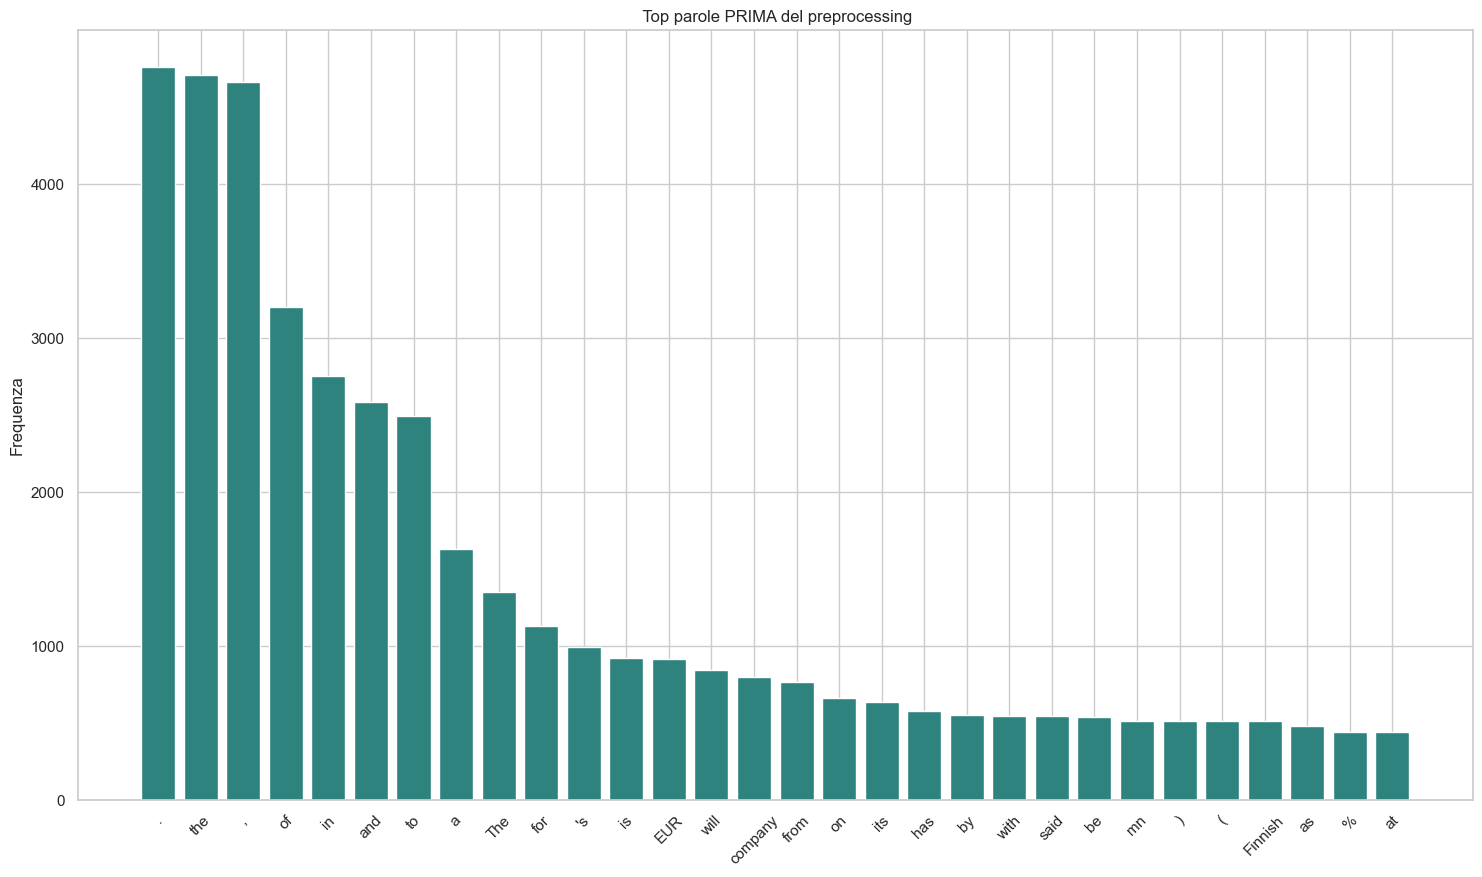

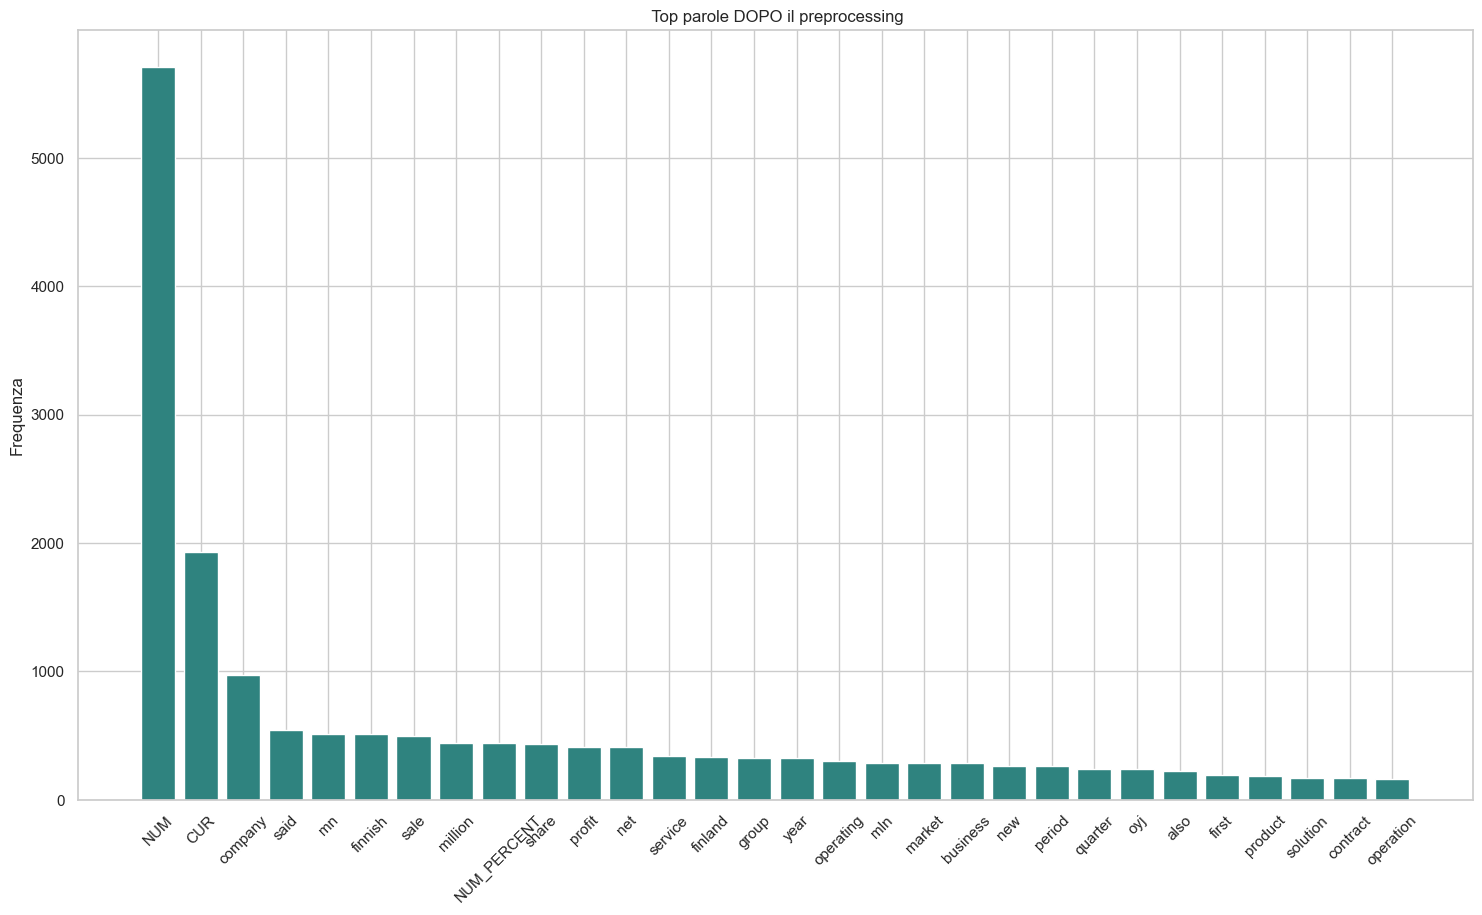

In [46]:
df = pd.read_csv("../data/processed/preprocessed_data.csv")

# Conto dei vocaboli unici prima e dopo il preprocessing
vectorizer_original = CountVectorizer()
vectorizer_cleaned = CountVectorizer()

vocab_original = vectorizer_original.fit(df['text']).get_feature_names_out()
vocab_cleaned = vectorizer_cleaned.fit(df['cleaned_text']).get_feature_names_out()

print(f"\n Vocaboli unici PRIMA del preprocessing: {len(vocab_original)}")
print(f" Vocaboli unici DOPO il preprocessing: {len(vocab_cleaned)}")

# DISTRIBUZIONE DELLE CLASSI
print("\n Distribuzione classi NEL DATASET:")
print(df['label'].value_counts())


# PAROLE PIÙ FREQUENTI PRIMA e DOPO ###

# Funzione per visualizzare le top parole
def plot_top_words(texts, title, n=30):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    common = word_counts.most_common(n)
    words, counts = zip(*common)

    plt.figure(figsize=(18,10))
    plt.bar(words, counts, color='#2f837f')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel("Frequenza")
    plt.show()

# Visualizza le parole più frequenti prima del preprocessing
plot_top_words(df['text'], " Top parole PRIMA del preprocessing")

# Visualizza le parole più frequenti dopo il preprocessing
plot_top_words(df['cleaned_text'], " Top parole DOPO il preprocessing")


## Distrubuzione dei vocaboli Unici - per classe

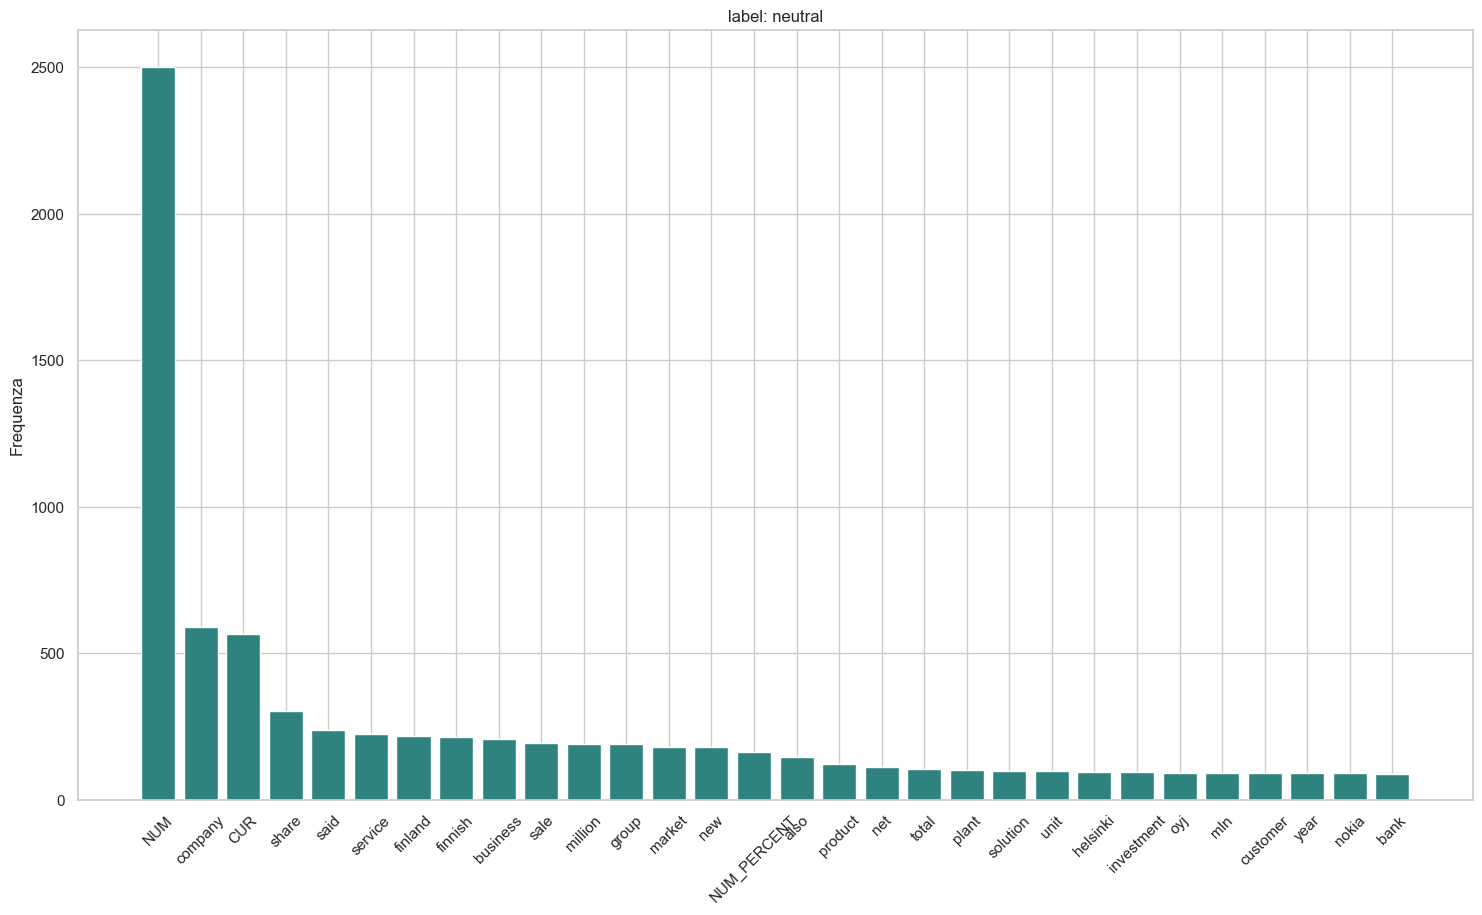

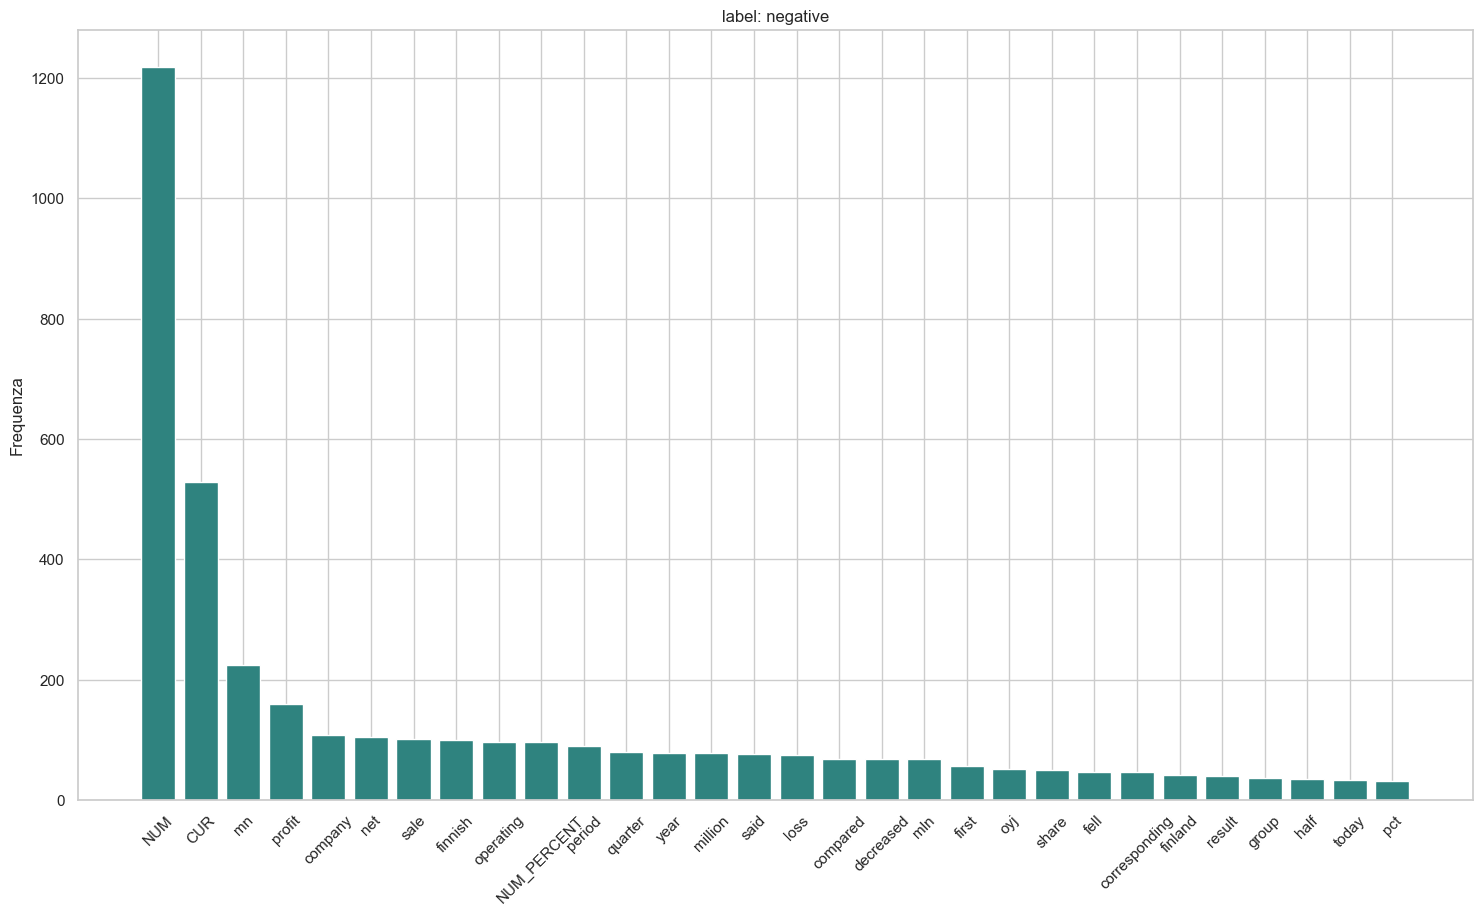

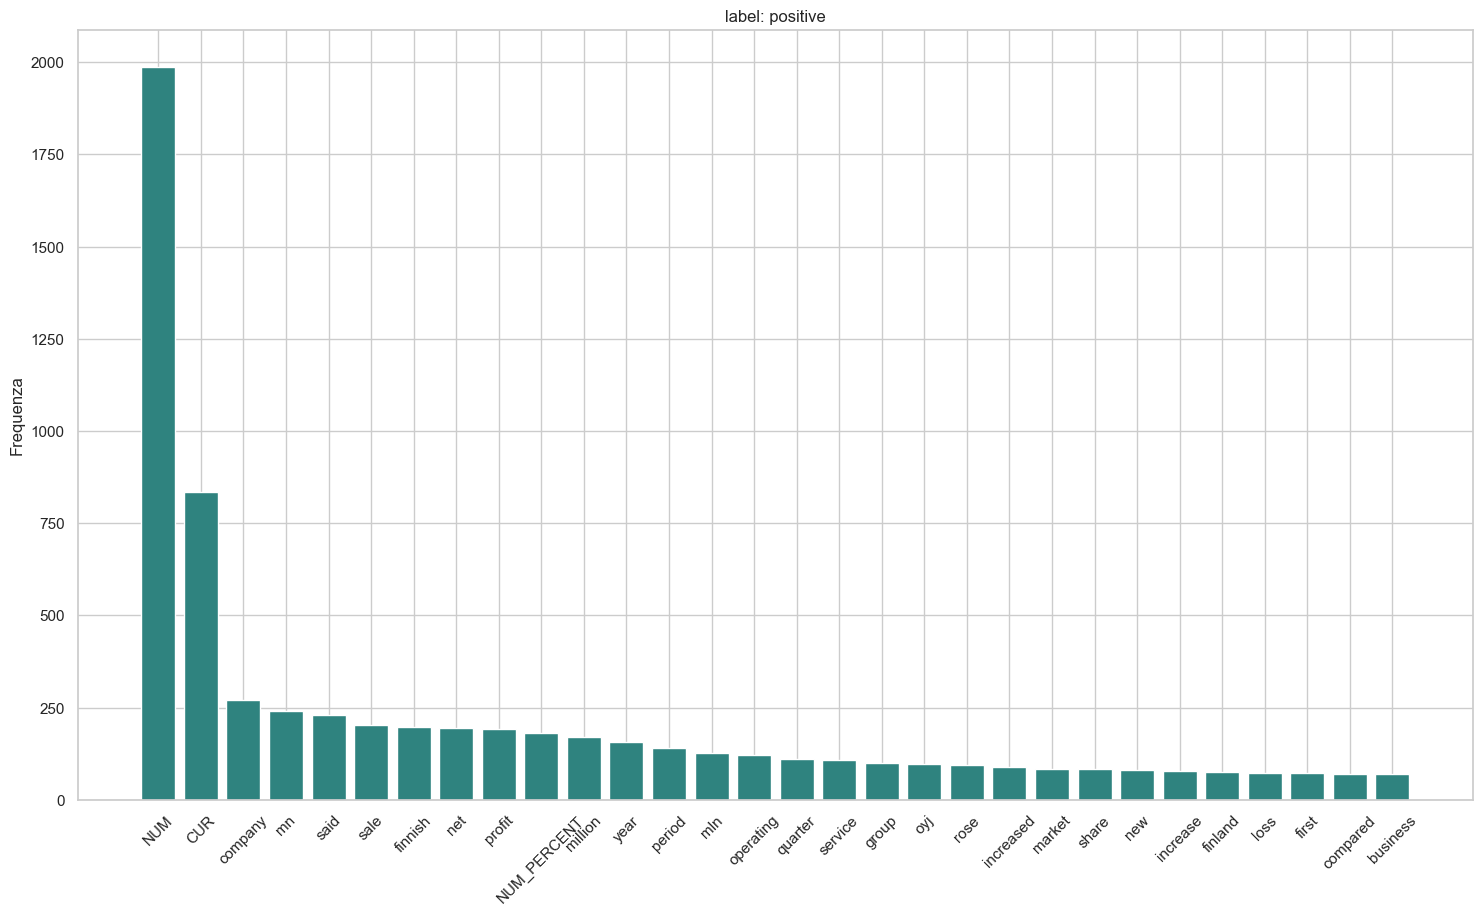

In [47]:
df = pd.read_csv("../data/processed/preprocessed_data.csv")

vocab_cleaned = vectorizer_cleaned.fit(df['cleaned_text']).get_feature_names_out()
def plot_top_words(texts, title, n=30):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    common = word_counts.most_common(n)
    words, counts = zip(*common)

    plt.figure(figsize=(18, 10))
    plt.bar(words, counts, color='#2f837f')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel("Frequenza")
    plt.show()

    return [word for word, count in common]

# Dizionario per salvare parole top per ogni label
top_words_per_label = {}

for label in df['label'].unique():
    texts_for_label = df[df['label'] == label]['cleaned_text']
    top_words = plot_top_words(texts_for_label, title=f"label: {label}")
    top_words_per_label[label] = top_words


**Classe Neutrale**
- Parole come oper, servic, product, group, invest, bank, solut, industri sembrano indicare testi descrittivi o neutrali, con focus su attività operative, prodotti e servizi, senza forte connotazione emotiva.

**Classe Negativa**
 - Sono presenti parole che indicano calo o perdita: decreas, loss, fell, compar, loss, quarter, period – che suggeriscono comunicazioni con notizie negative, come perdite o risultati inferiori alle aspettative.

**Classe Positiva**
  - Parole come increas, rose, order, percent indicano miglioramenti, crescita e risultati positivi. C’è anche profit e market in senso positivo associato a termini di guadagno.

## Bigrammi per classe

In [48]:
def plot_bigram(sentiment: str):
    # 🔧 Filtro solo i testi della classe "negative"
    negative_texts = df[df['label'] == sentiment]['cleaned_text']

    # 📈 Estrazione dei bigrammi (stopwords rimosse)
    vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
    X = vectorizer.fit_transform(negative_texts)

    # 🧮 Frequenza dei bigrammi
    sum_words = X.sum(axis=0)
    bigram_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

    # 🔝 Prendi i top 10 bigrammi
    top_bigrams = bigram_freq[:20]
    bigrams = [x[0] for x in top_bigrams]
    counts = [x[1] for x in top_bigrams]

    # 📊 Visualizzazione con barplot
    plt.figure(figsize=(10,6))
    plt.barh(bigrams[::-1], counts[::-1])  # inverti per avere il più frequente in alto
    plt.xlabel("Frequenza")
    plt.title(f"Top 20 Bigrammi nella classe {sentiment}")
    plt.tight_layout()
    plt.show()

    print(f'Top 20 Bigrammi classe {sentiment}: ')
    for couple in top_bigrams:
        print('(' + couple[0] + ' ' + str(couple[1]) + '),', end=' ')


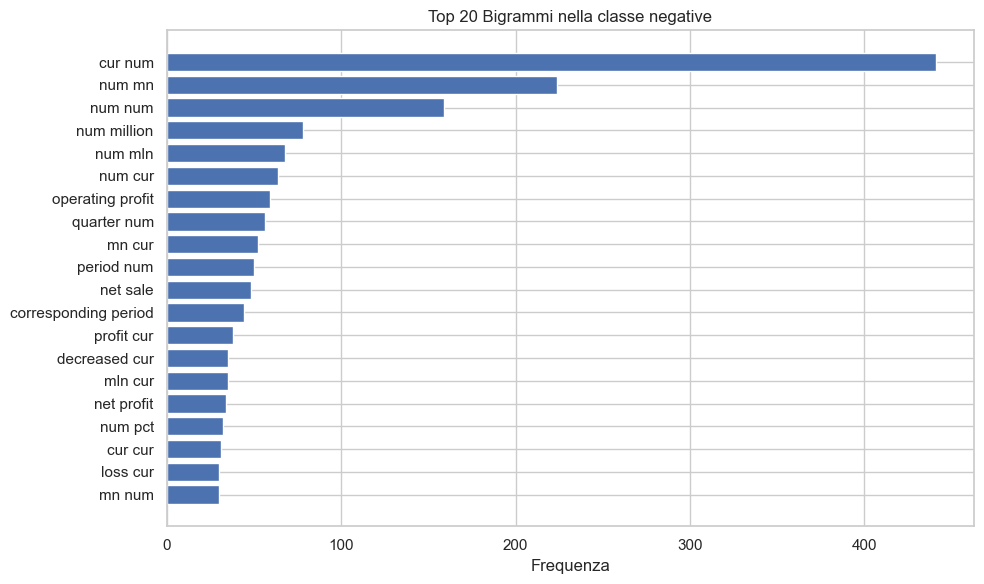

Top 20 Bigrammi classe negative: 
(cur num 441), (num mn 224), (num num 159), (num million 78), (num mln 68), (num cur 64), (operating profit 59), (quarter num 56), (mn cur 52), (period num 50), (net sale 48), (corresponding period 44), (profit cur 38), (decreased cur 35), (mln cur 35), (net profit 34), (num pct 32), (cur cur 31), (loss cur 30), (mn num 30), 

In [49]:
plot_bigram('negative')

### Analisi Bigrammi Negativo
Bigrammi/Pattern distintivi nella classe Negative:
- (decreas eur), (loss eur), (oper loss), (compar eur), (year earlier), (mn compar), (mn correspond)

**Presenza di parole con semantica negativa implicita: loss, decrease, earlier.**

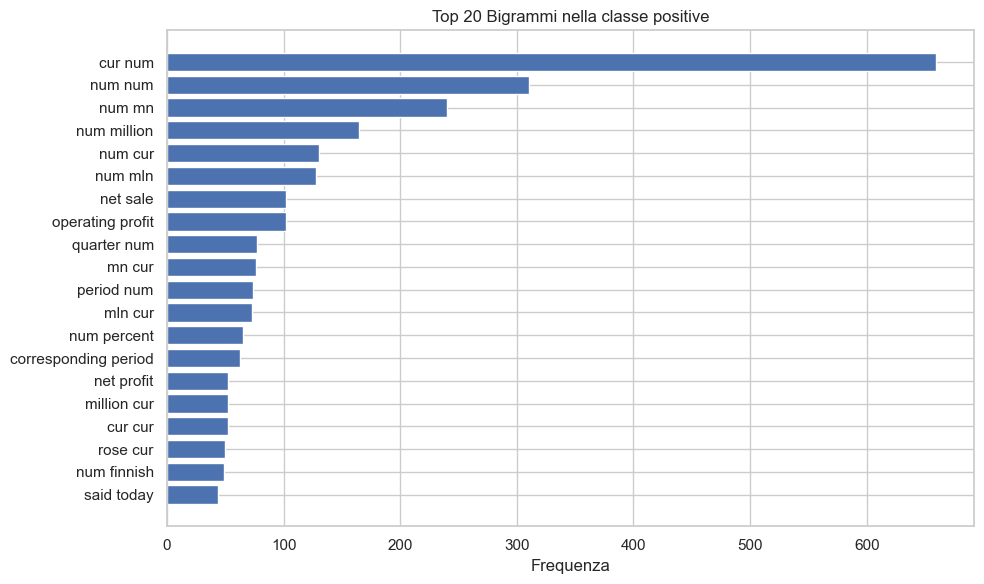

Top 20 Bigrammi classe positive: 
(cur num 659), (num num 310), (num mn 240), (num million 165), (num cur 130), (num mln 128), (net sale 102), (operating profit 102), (quarter num 77), (mn cur 76), (period num 74), (mln cur 73), (num percent 65), (corresponding period 63), (net profit 52), (million cur 52), (cur cur 52), (rose cur 50), (num finnish 49), (said today 44), 

In [50]:
plot_bigram('positive')

### Analisi Bigrammi Positivi
Bigrammi/Pattern distintivi nella classe Positive:
- (rose eur), (profit rose), (increas eur), (eur compar)
- (net profit) -> è presente anche nella classe Negative, ma in questo caso ha una frequenza maggiore.

**Parole orientate alla crescita, con verbi positivi: rose, increase.**

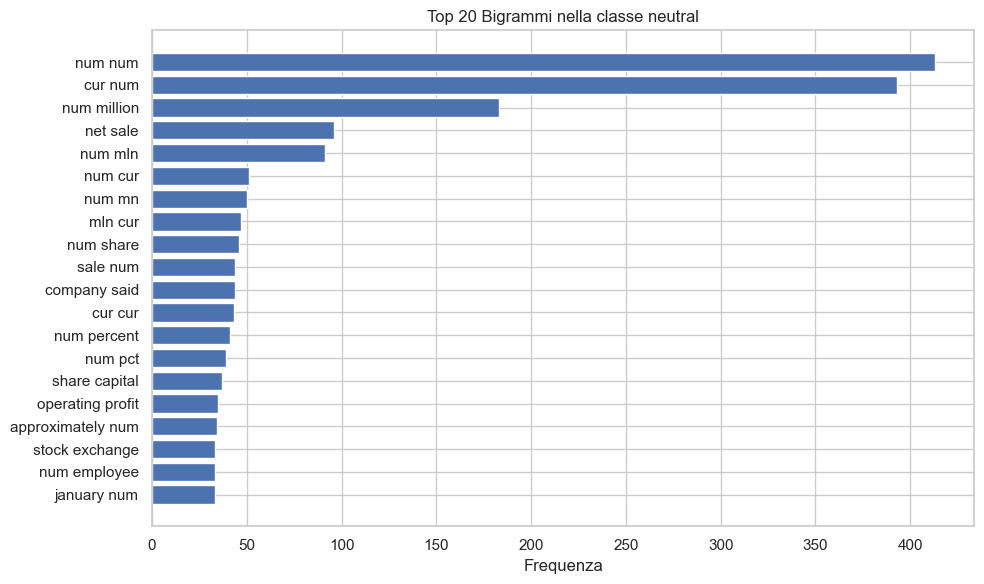

Top 20 Bigrammi classe neutral: 
(num num 413), (cur num 393), (num million 183), (net sale 96), (num mln 91), (num cur 51), (num mn 50), (mln cur 47), (num share 46), (sale num 44), (company said 44), (cur cur 43), (num percent 41), (num pct 39), (share capital 37), (operating profit 35), (approximately num 34), (stock exchange 33), (num employee 33), (january num 33), 

In [51]:
plot_bigram('neutral')

### Analisi Bigrammi Neutrali
Bigrammi/Pattern distintivi per la classe neutral sono:
- (compani said), (board director), (vote right), (real estat), (new share), (stock exchang), (alma medium), (stock option), (share capit)

Linguaggio informativo, strutturale, descrittivo, non orientato alla performance. Include eventi societari, governance, emissioni di azioni, contesto regolamentare, quindi **non è presente nessuna connotazione positiva o negativa forte.**

### Analisi Generale Bigrammi:
Ci sono alcuni bigrammi fortemente condivisi tra le 3 classi, che riflettono il linguaggio e termini utilizzati nel contesto dei report finanziari:
- (eur mn), (oper profit), (net sale), (net profit), (eur million), (mn eur), (mln euro), (euro mln), (correspond period), (total eur), (oyj hel)

Questi **non sono discriminanti tra classi**, ma sono utili per indicare che il testo è effettivamente finanziario.